In [1]:
import pandas as pd
import copulas
import copulae
from pandas_datareader import data
from scipy import stats
import numpy as np
from matplotlib import pyplot as plt
from copulas.multivariate import GaussianMultivariate
from copulas.visualization import compare_3d
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Creating Explanatory Factor Models

## Data Importing

In [2]:
# Set start and end dates
start_date = '2014-01-01'
end_date = '2019-12-31'

# Get the data
data = data.get_data_yahoo(["XLE","XLF","XLU","XLI","GDX","XLK","XLV","XLY","XLP","XLB","XOP","SPY"], start_date, end_date)['Close']
data.head()

Symbols,XLE,XLF,XLU,XLI,GDX,XLK,XLV,XLY,XLP,XLB,XOP,SPY
Date,,,,,,,,,,,,
2014-01-02,87.250000,17.660439,37.389999,51.529999,22.030001,35.389999,55.130001,66.519997,42.450001,45.849998,268.440002,182.919998
2014-01-03,86.930000,17.782291,37.270000,51.669998,21.830000,35.220001,55.259998,66.339996,42.369999,45.740002,266.000000,182.889999
2014-01-06,87.050003,17.798538,37.330002,51.369999,21.930000,35.160000,55.029999,65.930000,42.209999,45.490002,264.559998,182.360001
2014-01-07,87.709999,17.806662,37.660000,51.689999,21.969999,35.480000,55.610001,66.330002,42.439999,45.410000,267.000000,183.479996
2014-01-08,87.099998,17.863525,37.459999,51.599998,21.610001,35.480000,56.099998,66.150002,42.119999,45.680000,265.799988,183.520004


## Data Processing

In [3]:
returns = data.pct_change().dropna()
returns.head()

Symbols,XLE,XLF,XLU,XLI,GDX,XLK,XLV,XLY,XLP,XLB,XOP,SPY
Date,,,,,,,,,,,,
2014-01-03,-0.003668,0.006900,-0.003209,0.002717,-0.009079,-0.004804,0.002358,-0.002706,-0.001885,-0.002399,-0.009090,-0.000164
2014-01-06,0.001380,0.000914,0.001610,-0.005806,0.004581,-0.001704,-0.004162,-0.006180,-0.003776,-0.005466,-0.005414,-0.002898
2014-01-07,0.007582,0.000456,0.008840,0.006229,0.001824,0.009101,0.010540,0.006067,0.005449,-0.001759,0.009223,0.006142
2014-01-08,-0.006955,0.003193,-0.005311,-0.001741,-0.016386,0.000000,0.008811,-0.002714,-0.007540,0.005946,-0.004494,0.000218
2014-01-09,-0.003100,0.003638,0.005873,0.004845,-0.015733,-0.006483,0.007487,-0.000151,0.005223,-0.003940,-0.004063,0.000654


## Data Summaries - Extreme Values

In [4]:
    mean_returns = returns.mean()
    mean_returns

Symbols
XLE   -0.000161
XLF    0.000422
XLU    0.000402
XLI    0.000349
GDX    0.000458
XLK    0.000687
XLV    0.000451
XLY    0.000463
XLP    0.000289
XLB    0.000246
XOP   -0.000449
SPY    0.000409
dtype: float64

In [5]:
trim_means = pd.Series(stats.trim_mean(returns, 0.05), index= mean_returns.index)
trim_means

Symbols
XLE   -0.000060
XLF    0.000624
XLU    0.000631
XLI    0.000569
GDX    0.000479
XLK    0.000923
XLV    0.000629
XLY    0.000693
XLP    0.000462
XLB    0.000400
XOP   -0.000550
SPY    0.000643
dtype: float64

The lowest and highest 5% percentiles were considered outliers and were excluded from the mean computation.

In [6]:
def find_iqr(x):
    return np.subtract(np.percentile(x, 75),np.percentile(x, 25))
iqr = returns.apply(find_iqr)
iqr

Symbols
XLE    0.014201
XLF    0.010752
XLU    0.009971
XLI    0.009762
GDX    0.025338
XLK    0.010191
XLV    0.009959
XLY    0.009759
XLP    0.008184
XLB    0.011526
XOP    0.025626
SPY    0.007672
dtype: float64

In [7]:
std = returns.std()
std

Symbols
XLE    0.013144
XLF    0.010388
XLU    0.008848
XLI    0.009485
GDX    0.023219
XLK    0.010596
XLV    0.009414
XLY    0.009250
XLP    0.007353
XLB    0.010248
XOP    0.021962
SPY    0.008286
dtype: float64

Both these indicators measure the spread of the data (i.e. the returns)

In [8]:
median = returns.median()
median

Symbols
XLE    0.000000
XLF    0.000760
XLU    0.001018
XLI    0.000753
GDX    0.000322
XLK    0.001017
XLV    0.000861
XLY    0.001104
XLP    0.000440
XLB    0.000651
XOP    0.000000
SPY    0.000516
dtype: float64

In [9]:
diff = median-mean_returns
diff

Symbols
XLE    0.000161
XLF    0.000338
XLU    0.000616
XLI    0.000404
GDX   -0.000136
XLK    0.000330
XLV    0.000410
XLY    0.000641
XLP    0.000152
XLB    0.000404
XOP    0.000449
SPY    0.000107
dtype: float64

In [10]:
skew = returns.skew()
skew

Symbols
XLE   -0.117672
XLF   -0.374614
XLU   -0.565169
XLI   -0.443125
GDX   -0.026566
XLK   -0.389786
XLV   -0.332189
XLY   -0.348155
XLP   -0.449950
XLB   -0.234586
XOP    0.107981
SPY   -0.469261
dtype: float64

It seems that, in most occurences, this difference correlates with the skewness. More precisely, when the median is larger than the mean (mean left of the median), the data is negatively skewed.

In [11]:
kurtosis = returns.kurtosis()
kurtosis

Symbols
XLE    1.794336
XLF    2.569157
XLU    1.697737
XLI    2.248227
GDX    1.895774
XLK    3.394845
XLV    2.073538
XLY    2.969517
XLP    1.944691
XLB    1.482196
XOP    2.203666
SPY    3.775246
dtype: float64

In [12]:
results = pd.DataFrame()
for i in range(5000):
    results[i] = returns.sample(200, replace = True).std()
    
results

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
Symbols,,,,,,,,,,,,,,,,,,,,,
XLE,0.012841,0.013222,0.012574,0.012783,0.012419,0.014646,0.014539,0.014041,0.013026,0.013309,...,0.012990,0.012187,0.013116,0.014648,0.013362,0.013490,0.011418,0.012326,0.014133,0.012381
XLF,0.010984,0.009562,0.009802,0.011223,0.010801,0.011555,0.011287,0.012369,0.009229,0.010634,...,0.011346,0.008884,0.009809,0.009663,0.010282,0.010497,0.010664,0.008292,0.010919,0.009278
XLU,0.008121,0.008441,0.007896,0.007738,0.010361,0.008529,0.009715,0.009340,0.008651,0.008759,...,0.008990,0.007807,0.008040,0.008916,0.007981,0.009372,0.007907,0.008812,0.008242,0.008402
XLI,0.009796,0.009077,0.009238,0.010486,0.009498,0.010828,0.010198,0.011232,0.008899,0.009597,...,0.010417,0.008222,0.008746,0.009087,0.009373,0.009117,0.008975,0.007888,0.010142,0.008299
GDX,0.020824,0.023486,0.022942,0.021459,0.024355,0.025849,0.022672,0.023057,0.023246,0.023948,...,0.023129,0.022268,0.025440,0.023230,0.022090,0.026445,0.022872,0.025456,0.021207,0.022682
XLK,0.010328,0.009874,0.010459,0.011699,0.011199,0.011688,0.012034,0.012403,0.009407,0.011155,...,0.011763,0.009324,0.009381,0.010561,0.010414,0.010947,0.010875,0.008745,0.010971,0.010404
XLV,0.009151,0.008619,0.009861,0.009664,0.009675,0.009868,0.010290,0.010677,0.008075,0.010464,...,0.009516,0.008094,0.009287,0.008581,0.008996,0.009604,0.009446,0.008126,0.009702,0.008770
XLY,0.008897,0.008585,0.009305,0.010328,0.009872,0.010292,0.010244,0.010058,0.008754,0.009673,...,0.010099,0.007991,0.008020,0.008681,0.009319,0.009358,0.009606,0.007663,0.009417,0.009162
XLP,0.007499,0.007061,0.007147,0.007575,0.006984,0.007639,0.007347,0.008524,0.006950,0.007310,...,0.007491,0.006128,0.006497,0.006991,0.007097,0.007443,0.006847,0.006277,0.007083,0.006842


In [13]:
results.std(axis = 1)

Symbols
XLE    0.000913
XLF    0.000772
XLU    0.000609
XLI    0.000686
GDX    0.001616
XLK    0.000864
XLV    0.000669
XLY    0.000730
XLP    0.000517
XLB    0.000670
XOP    0.001597
SPY    0.000700
dtype: float64

In [14]:
stats.pearsonr(np.array(results.std(axis =1)), np.array(kurtosis))

(-0.09397191648044301, 0.7714423486773723)

The two measure correlates positively. The higher the volatility of the standard deviation, the higher the kurtosis.

In [15]:
np.array(kurtosis)

array([1.79433572, 2.56915689, 1.69773693, 2.24822682, 1.89577362,
       3.39484542, 2.07353842, 2.96951748, 1.94469147, 1.48219628,
       2.2036659 , 3.77524617])

The average returns for the SPDRs are close to zero. There seem to be larger negative returns as compared to positive ones that skews the data negatively. The data has relatively heavy tails. This is what we would expect from financial data.

## Data Inference

In [16]:
#Normality Test
f1 = returns.iloc[:,0]
k1, p1 = stats.normaltest(f1)
p1

1.8737448052308446e-15

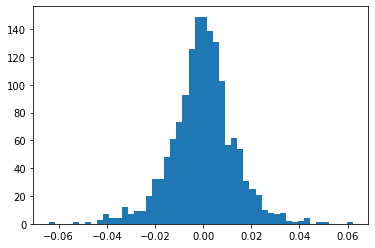

In [17]:
%matplotlib inline
plt.hist(f1, bins = 50)
plt.show()

The null hypothesis can be rejected and the data does not fit the normal distribution well. This is most likely cause by outliers (i.e. large positive and negative returns corresponding to periods of financial stress).

In [18]:
#Normality Test on 2nd fund
f2 = returns.iloc[:,1]
k2, p2 = stats.normaltest(f2)
p2

1.24315437768306e-28

(array([  1.,   1.,   0.,   0.,   1.,   2.,   0.,   0.,   3.,   0.,   4.,
          4.,   5.,   4.,   7.,  11.,  13.,  13.,  15.,  24.,  34.,  36.,
         65.,  74.,  85., 135., 153., 156., 142., 123.,  90.,  83.,  55.,
         40.,  45.,  26.,  18.,   8.,  10.,   7.,   6.,   2.,   0.,   2.,
          1.,   1.,   1.,   0.,   2.,   1.]),
 array([-0.05357897, -0.05160196, -0.04962496, -0.04764796, -0.04567096,
        -0.04369395, -0.04171695, -0.03973995, -0.03776294, -0.03578594,
        -0.03380894, -0.03183193, -0.02985493, -0.02787793, -0.02590092,
        -0.02392392, -0.02194692, -0.01996991, -0.01799291, -0.01601591,
        -0.0140389 , -0.0120619 , -0.0100849 , -0.0081079 , -0.00613089,
        -0.00415389, -0.00217689, -0.00019988,  0.00177712,  0.00375412,
         0.00573113,  0.00770813,  0.00968513,  0.01166214,  0.01363914,
         0.01561614,  0.01759315,  0.01957015,  0.02154715,  0.02352416,
         0.02550116,  0.02747816,  0.02945516,  0.03143217,  0.03340917,
 

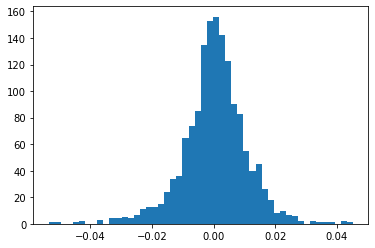

In [19]:
%matplotlib inline
plt.hist(f2, bins = 50)

The null hypothesis can be rejected and the data does not fit the normal distribution well. This is most likely cause by outliers (i.e. large positive and negative returns corresponding to periods of financial stress).

The Cauchy distribution is a fat-tailed distribution that can sometimes better fit financial data as it accounts for large positive and negative returns.

## Data Comparison - Copulas 

In [20]:
m = pd.DataFrame((f1,f2)).transpose()
m



,XLE,XLF
Date,,
2014-01-03,-0.003668,0.006900
2014-01-06,0.001380,0.000914
2014-01-07,0.007582,0.000456
2014-01-08,-0.006955,0.003193
2014-01-09,-0.003100,0.003638
...,...,...
2019-12-24,-0.000484,0.002287
2019-12-26,-0.000323,0.005541
2019-12-27,-0.004198,-0.002593


###### RUN THE NEXT CELL TWICE. I DO NOT KNOW WHY? BUT IT TENDS NOT TO WORK THE FIRST TIME AND TO WORK THEREAFTER


C:\Users\louis\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:621: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
C:\Users\louis\anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\louis\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:4965: RuntimeWarning: divide by zero encountered in true_divide
  return c**2 / (c**2 - n**2)
C:\Users\louis\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2429: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
C:\Users\louis\anaconda3\lib\site-packages\copulas\univariate\truncated_gaussian.py:43: RuntimeWarning: divide by zero encountered in double_scalars
  a = (self.min - loc) / scale
C:\Users\louis\anaconda3\lib\site-packages\copula

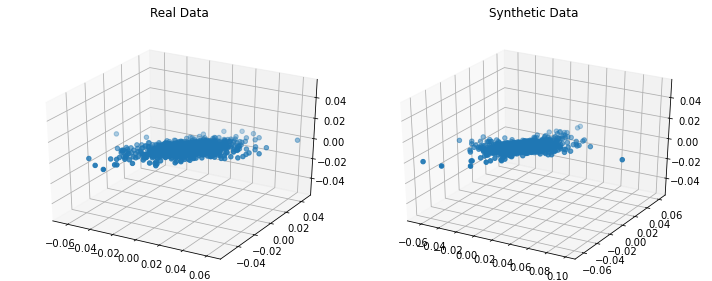

In [21]:
copul = GaussianMultivariate()
dist = copul.fit(m)
synthetic_data = copul.sample(len(m))
compare_3d(m, synthetic_data)

In [22]:
#Student Copula
sc = copulae.elliptical.StudentCopula(dim = 2)
fit_2 = sc.fit(m, method = 'ml')
fit_2

# Estimate of the correlation for Gaussian copula and student copula correlation

### - Correlation for the Gaussian copula is obtained by estimating the covariance matrix using the log-likelihood method, and then normalising the covariance estimate.

### - Correlation for the student copula:ρ=sin⁡(1/2.π.τ) where τ is the Kendal's tau.

#### source: https://support.sas.com/documentation/cdl/en/etsug/63939/HTML/default/viewer.htm#etsug_copula_sect015.htm 


# Which Correlation is preferred?

### The rank correlation could be preferred as it applies to both linear and nonlinear relationships and is thus robust, while the Gaussian correlation applies to linear relationships only.

## Category 1 Models: Lasso and PCA

### LASSO

In [23]:
#Define variables
y = returns.iloc[:,-1]
X = returns.iloc[:,:-1]

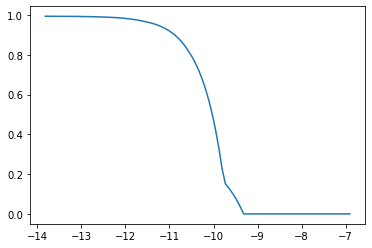

In [24]:
#Split data into train/test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,shuffle = False)

#Create empty dataframe to store resutls
results = pd.DataFrame(columns = ['coefs','nb_predictors','score','mse'], index =np.linspace(0,0.001, 1001)[1:] )
results.index.name = 'alpha'

#loop over alphas
for alpha in results.index:
    #Fit Model
    lasso = Lasso(alpha=alpha, max_iter = 10000)
    lasso.fit(X_train,y_train)
    
    #Make Predictions
    preds = lasso.predict(X_test)

    #Store Results
    results.loc[alpha,'score'] = lasso.score(X_test,y_test)
    results.loc[alpha,'nb_predictors'] = np.sum(lasso.coef_!=0)
    results.loc[alpha,'coefs'] = lasso.coef_
    results.loc[alpha,'mse'] = mean_squared_error(y_test,preds)

#Plot scores vs alphas
plt.plot(np.log(results.index),results['score'])   

In [25]:
#Find what are the best predictors for 5 predictors
results[results['nb_predictors'] == 5].sort_values('score', ascending = False).iloc[0,:]

coefs            [0.0, 0.16370667190690863, 0.0, 0.011554819225...
nb_predictors                                                    5
score                                                     0.827664
mse                                                    1.55261e-05
Name: 2.4999999999999998e-05, dtype: object

In [26]:
returns.head()

Symbols,XLE,XLF,XLU,XLI,GDX,XLK,XLV,XLY,XLP,XLB,XOP,SPY
Date,,,,,,,,,,,,
2014-01-03,-0.003668,0.006900,-0.003209,0.002717,-0.009079,-0.004804,0.002358,-0.002706,-0.001885,-0.002399,-0.009090,-0.000164
2014-01-06,0.001380,0.000914,0.001610,-0.005806,0.004581,-0.001704,-0.004162,-0.006180,-0.003776,-0.005466,-0.005414,-0.002898
2014-01-07,0.007582,0.000456,0.008840,0.006229,0.001824,0.009101,0.010540,0.006067,0.005449,-0.001759,0.009223,0.006142
2014-01-08,-0.006955,0.003193,-0.005311,-0.001741,-0.016386,0.000000,0.008811,-0.002714,-0.007540,0.005946,-0.004494,0.000218
2014-01-09,-0.003100,0.003638,0.005873,0.004845,-0.015733,-0.006483,0.007487,-0.000151,0.005223,-0.003940,-0.004063,0.000654


The 5 best predictors are XLF, XLI, XLK, XLV and XOP

### PCA - Correlation Matrix

In [27]:
#Standardize the returns
returns_z = (returns-returns.mean())/returns.std()

In [28]:
#PCA
X=returns_z.iloc[:,:-1]
y=returns_z.iloc[:,-1]
pca_corr = PCA()
pca_corr.fit(X)

PCA()

In [29]:
#Cummulative variance explained
cum_ratio = pca_corr.explained_variance_ratio_.cumsum()
cum_ratio

array([0.56784856, 0.68980493, 0.80262723, 0.86305191, 0.89515816,
       0.92314163, 0.94996048, 0.96916647, 0.98237089, 0.99399491,
       1.        ])

In [30]:
#Transformm explanatory space into space of dim 5
X_proj_corr = pca_corr.transform(X)
X_proj_corr = X_proj_corr[:,:5]
X_proj_corr.shape

(1509, 5)

In [31]:
#Fit Model to the data
linreg_corr = LinearRegression()
linreg_corr.fit(X_proj_corr,y)

#Make Predictions
predictions_corr = linreg_corr.predict(X_proj_corr)

#Model Summary
mse_corr = np.mean((predictions_corr-y)**2)
print ('intercept:', linreg_corr.intercept_)
print('coefs:', linreg_corr.coef_)
print('score:', linreg_corr.score(X_proj_corr,y))
print('mse:', mse_corr)

intercept: 2.256015627495708e-17
coefs: [ 0.39319016  0.08995286  0.07001594 -0.08062062 -0.08601592]
score: 0.9895459015149412
mse: 0.010447170653060766


## PCA - Covariance

In [32]:
#PCA
X=returns.iloc[:,:-1]
y=returns.iloc[:,-1]
pca = PCA()
pca.fit(X)

PCA()

In [33]:
cum_ratio = pca.explained_variance_ratio_.cumsum()
cum_ratio

array([0.48182956, 0.75969165, 0.884291  , 0.92291606, 0.94180361,
       0.95727033, 0.96917351, 0.97887381, 0.98711785, 0.99375751,
       1.        ])

In [34]:
X_proj = pca.transform(X)
X_proj = X_proj[:,:5]
X_proj.shape

(1509, 5)

In [35]:
#Fit Model to the data
linreg = LinearRegression()
linreg.fit(X_proj,y)

#Make Predictions
predictions = linreg.predict(X_proj)

#Model Summary
mse = np.mean((predictions-y)**2)
print ('intercept:', linreg.intercept_)
print('coefs:', linreg.coef_)
print('score:', linreg.score(X_proj,y))
print('mse:', mse)

intercept: 0.00040892560940975164
coefs: [ 0.22452859 -0.10669682 -0.2524084   0.02530844 -0.09885869]
score: 0.9934131493277274
mse: 4.519677483910807e-07


## Trimmed Data PCA - Corr

In [36]:
#remove outliers from data
quantiles = returns.quantile([0.025, 0.975])
returns_trimmed = returns.apply(lambda x: x[(x>quantiles.loc[0.025,x.name]) & 
                                    (x < quantiles.loc[0.975,x.name])]).dropna()

In [37]:
returns_trimmed.shape

(1156, 12)

In [38]:
returns.shape

(1509, 12)

In [39]:
#Standardize the returns
returns_z = (returns_trimmed-returns_trimmed.mean())/returns_trimmed.std()

In [40]:
#PCA
X=returns_z.iloc[:,:-1]
y=returns_z.iloc[:,-1]
pca_corr = PCA()
pca_corr.fit(X)

PCA()

In [41]:
#Cummulative variance explained
cum_ratio = pca.explained_variance_ratio_.cumsum()
cum_ratio

array([0.48182956, 0.75969165, 0.884291  , 0.92291606, 0.94180361,
       0.95727033, 0.96917351, 0.97887381, 0.98711785, 0.99375751,
       1.        ])

In [42]:
#Transformm explanatory space into space of dim 5
X_proj_corr = pca_corr.transform(X)
X_proj_corr = X_proj_corr[:,:5]
X_proj_corr.shape

(1156, 5)

In [43]:
#Fit Model to the data
linreg_corr = LinearRegression()
linreg_corr.fit(X_proj_corr,y)

#Make Predictions
predictions_corr = linreg_corr.predict(X_proj_corr)

#Model Summary
mse_corr = np.mean((predictions_corr-y)**2)
print ('intercept:', linreg_corr.intercept_)
print('coefs:', linreg_corr.coef_)
print('score:', linreg_corr.score(X_proj_corr,y))
print('mse:', mse_corr)

intercept: 1.6004336129015414e-17
coefs: [-0.43944437 -0.12305456  0.04946116  0.05278261 -0.11840806]
score: 0.9792744193040864
mse: 0.020707651992889358


## PCA - Covariance

In [44]:
#PCA
X=returns_trimmed.iloc[:,:-1]
y=returns_trimmed.iloc[:,-1]
pca = PCA()
pca.fit(X)

PCA()

In [45]:
cum_ratio = pca.explained_variance_ratio_.cumsum()
cum_ratio

array([0.41310135, 0.69951935, 0.83815699, 0.88599464, 0.91205009,
       0.93359364, 0.95128146, 0.96638643, 0.97899705, 0.98993716,
       1.        ])

In [46]:
X_proj = pca.transform(X)
X_proj = X_proj[:,:5]
X_proj.shape

(1156, 5)

In [47]:
#Fit Model to the data
linreg = LinearRegression()
linreg.fit(X_proj,y)

#Make Predictions
predictions = linreg.predict(X_proj)

#Model Summary
mse = np.mean((predictions-y)**2)
print ('intercept:', linreg.intercept_)
print('coefs:', linreg.coef_)
print('score:', linreg.score(X_proj,y))
print('mse:', mse)

intercept: 0.0005394825521598332
coefs: [-0.14902563 -0.10277525 -0.29672746  0.01342071 -0.10664301]
score: 0.9839826514123542
mse: 4.11991121464015e-07


Removing the outliers seems to impact the model fit. Indeed the scores from the PCA regressions are reduced after removing the outliers and the fit is not as good.

What are the key differences in the methods between LASSO and PCA?


Both methods try to reduce the dimension of the explanatory space. In the PCA, we select the directions of larger variance as these are considered to be the directions that have the largest explanatory power. These directions are combinations of the initial explanatory vectors and are therfore more difficult to interpret. On the contrary, the Lasso regressions conserves the original explanatory variables and applies a penalty to any extra variable added in the regression model. This ensure parsimony of the model.

Compare the model results.

The lasso regression with 5 regressors gives an overall score of approximately 0.83. This is much lower from the results of any of the PCA regressions performed above (min score = 0. 98). Therefore the PCA seems to have a better performance than the LASSO. However, this performance comes with a cost in terms of interpretability of the results as the original regressors are not conserved.

 ## Category 2 Models Trees and SVM

### Regression Tree

In [48]:
y = returns.iloc[:,-1]
X = returns.iloc[:,:-1]

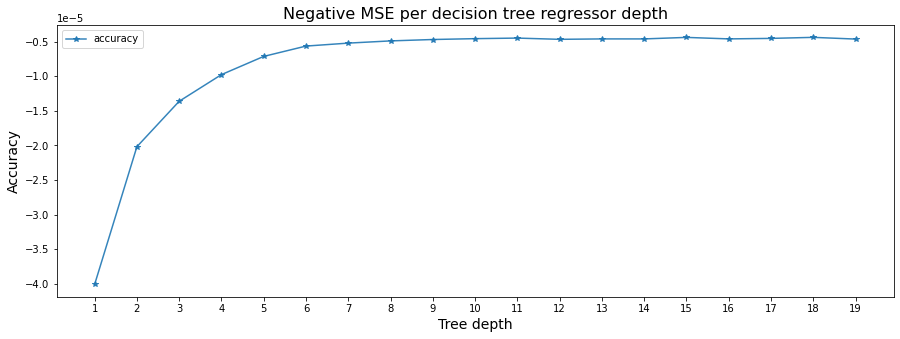

In [49]:
tree_depths = range(1,20)

nmse_cv_scores = [] # negative mean square errors
for depth in tree_depths:
    tree_model = DecisionTreeRegressor(max_depth=depth)
    cv_scores = cross_val_score(tree_model, X, y, cv=10, scoring='neg_mean_squared_error')
    nmse_cv_scores.append(cv_scores.mean())

# function for plotting cross-validation results
def plot_cross_validation_on_trees(depths, accuracy_scores, title):
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    ax.plot(depths, accuracy_scores, '-*', label='accuracy', alpha=0.9)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Tree depth', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_xticks(depths)
    ax.legend()

# plotting accuracy
plot_cross_validation_on_trees(tree_depths,nmse_cv_scores, 
                               'Negative MSE per decision tree regressor depth')


In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

reg = DecisionTreeRegressor(max_depth=3).fit(X_train, y_train)
print("r-squared:", reg.score(X_test, y_test))

r-squared: 0.8187759004242235


### SVM

In [51]:
regr = make_pipeline(StandardScaler(),LinearSVR(random_state=0, tol=1e-5))
regr.fit(X, y).score(X,y)

C:\Users\louis\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


0.9915470941235984

### Regression Tree - Trimmed data

In [52]:
y = returns_trimmed.iloc[:,-1]
X = returns_trimmed.iloc[:,:-1]

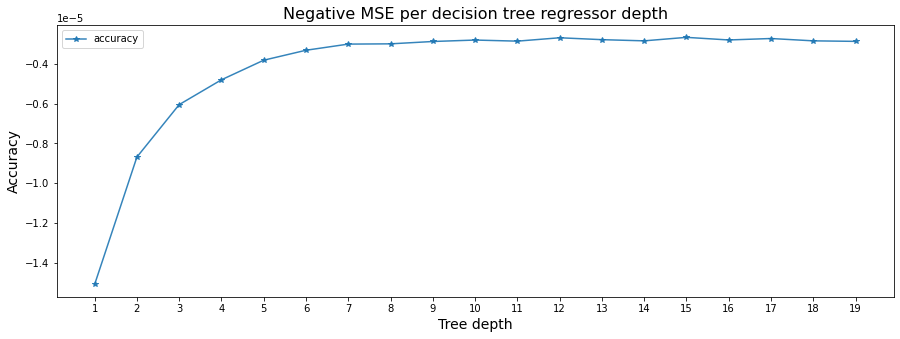

In [53]:
tree_depths = range(1,20)

nmse_cv_scores = [] # negative mean square errors
for depth in tree_depths:
    tree_model = DecisionTreeRegressor(max_depth=depth)
    cv_scores = cross_val_score(tree_model, X, y, cv=10, scoring='neg_mean_squared_error')
    nmse_cv_scores.append(cv_scores.mean())

# plotting accuracy
plot_cross_validation_on_trees(tree_depths,nmse_cv_scores, 
                               'Negative MSE per decision tree regressor depth')


In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

reg = DecisionTreeRegressor(max_depth=3).fit(X_train, y_train)
print("r-squared:", reg.score(X_test, y_test))

r-squared: 0.7581777557357531


### SVM - Trimmed Data

In [55]:
regr = make_pipeline(StandardScaler(),LinearSVR(random_state=0, tol=1e-5))
regr.fit(X, y).score(X,y)

C:\Users\louis\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


0.9718236475126544

What are the differences when you exclude the 5%?

Similarly to with the LASSO and PCA regressions, the SVM and Regression Tree models are performing worse whe trimming the 5% outliers (the scores are lower).

What are the key differences in the methods between CART and SVM?

Both can be used in classification and regression tasks and can support numerical and categorical data. They are considered non-parametric, thus making no assumption on the distribution of data and the structure of the model. The core idea behind them is to separate the data in classes, reducing the dimension as they go. SVM actually separates the classes with a decision surface that maximizes the margin between the classes, while in a decision tree structure, each node makes a binary decision that separates either one class or some of the classes from the remaining classes.

SVM uses kernels to turn linearly nonseparable problems into linearly separable, while decision trees split the input space into hyper-rectangles according to the target.

Compare the results of the models.

The SVM model is performing better than the Regression Tree with an overall score of 0.99 against 0.81. However, such model is also less easily interpretable.